In [2]:
pip install tprdbreader

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os.path
import sys
import numpy as np
import pandas as pd

import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique

from tprdbreader import readTPRDBtable_GCP



# Read Sessions
1. Read Spanish and Arabic sessions
1. Plot Paues Distribution
1. Compute within-word (WW) and between word (BW), Respites and TSF-pauses per participant
1. Plot relation keystroke-bigram frequency / average WW IKI
1. Relation WW/BW --- Respites/TSF-pauses

In [4]:
# read test data from study 

ext = "kd"
# experiment with different language pairs
KDdf = readTPRDBtable_GCP(["BML12","AR20"], ext, user = "TPRDB", verbose=1)

# Read multiple languages
KDdfM = readTPRDBtable_GCP(["BML12","AR20","SG12","KTHJ08","NJ12"], ext, user = "TPRDB", verbose=1)

# experiment with different language pairs
#KDdf = TPRDB.readTPRDBtables(["BML12/Tables/","AR20/Tables/"], "*kd", path=path, verbose = 1)

# Read multiple languages
#KDdfM = TPRDB.readTPRDBtables(["BML12/Tables/", "AR20/Tables/", "SG12/Tables/","KTHJ08/Tables/","NJ12/Tables/"], "*kd", path=path, verbose = 1)

print(KDdf.shape)

BML12	#sessions: 184	.kd:93117
AR20	#sessions: 123	.kd:48771
BML12	#sessions: 184	.kd:93117
AR20	#sessions: 123	.kd:48771
SG12	#sessions: 139	.kd:100706
KTHJ08	#sessions: 69	.kd:72383
NJ12	#sessions: 100	.kd:88950
(141888, 25)


In [4]:
# set 'StudyPart' to make it unique for each study 
KDdf['StudyPart'] = KDdf['Study'] +'_'+ KDdf['Part']

# extract set of translations
KDdfT = KDdf[(KDdf["Task"] == "T")]


## Distribution of IKIs, IKI Mean and Median for 5 Languages

0 ar mean:844.66 median: 265
1 da mean:382.87 median: 160
2 de mean:761.49 median: 156
3 es mean:493.44 median: 156
4 hi mean:1223.90 median: 374


<Figure size 720x432 with 0 Axes>

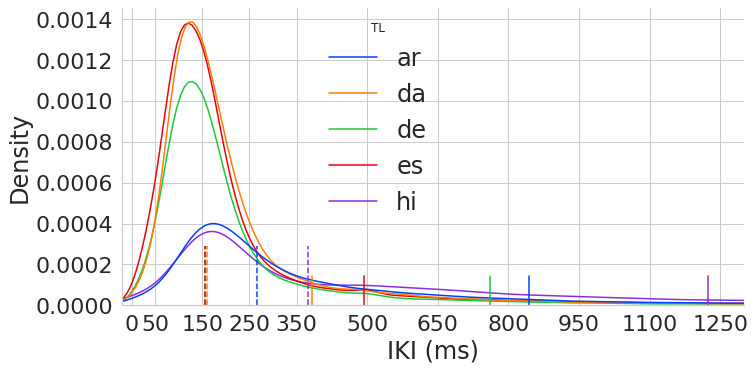

In [12]:
# Extract translation sessions with Pauses < 1500 ms
KDdfPauses = KDdfM[(KDdfM["Task"] == "T") & (KDdfM["Pause"] < 1500)]

# show languages in alphabetic order
hue_order = sorted(list(set(KDdfPauses['TL'])))

# plot figure
fig = plt.figure(figsize=(10,6))

sns.set(font_scale=1)
sns.set_style("whitegrid")

# Plot Pause distributions with density 
g = sns.displot(KDdfPauses, x=KDdfPauses['Pause'], hue='TL', kind='kde', fill=False, hue_order=hue_order,
            palette=sns.color_palette('bright')[:5], alpha=1, height=5, aspect=2.0)

# set x-ticks
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1100,1200,1300]) 
plt.xticks([0, 50, 150, 250, 350, 500, 650, 800, 950, 1100, 1250]) 
plt.xlim(-20, 1300)

# compute and plot mean and median pauses
# Extract all translation sessions
KDdfDist = KDdfM[(KDdfM["Task"] == "T")]

for i, tl in enumerate(hue_order):
    m = np.mean(KDdfDist[KDdfDist['TL'] == tl]['Pause'])
    plt.axvline(m, 0, 0.10, color= sns.color_palette('bright')[i], linestyle='-')
    
    n = np.median(KDdfDist[KDdfDist['TL'] == tl]['Pause'])
    plt.axvline(n, 0, 0.2, color= sns.color_palette('bright')[i], linestyle='--')
    print(f"{i} {tl} mean:{m:4.2f} median:{n:4.0f}")

# Add labels and a legend
#plt.title('Distribution of IKIs < 1300ms for five languages', size=16)
plt.xlabel('IKI (ms)', size=24)
plt.ylabel('Density', size=24)
plt.xticks(size=22)
plt.yticks(size=22)
sns.move_legend(g, "upper center", fontsize=24, title='TL')
plt.grid(True, which='both')

                
plt.show()


## Cumulative distribution per participant and Study for IKIs < Xlimit (AR20 and BML12) 
- generate Cumulative Distribution per participant 
    - sort pauses
    - extract pauses < 2000 ms
    - compute probability for each pause
- sort pauses per session and bring into a long format

In [950]:

# limit of X axis: maximum IKI in ms
Xlimit = 1000

# variable to store CDF 
H = {}

# produce CDF per participant
PartStudy = set(KDdfT['StudyPart'])    
for p in PartStudy:
    
    # sort pauses per participant 
    s1 = np.sort(KDdfT[KDdfT['StudyPart'] == p]['Pause'])
    LEN = len(s1)

    # probability per sample 
    cdf = [i/LEN for i in range(1, LEN +1)]

    # chop off at IKI for Xlimit
    X = [i for i in s1 if i < Xlimit]
    Y = cdf[:len(X)]

    H.setdefault(p,{})
    for n, y1 in enumerate(Y):
        H[p][y1] = X[n]

# extract studies (BML12 and AR20)
Study = set(KDdfT['Study'])

# generate Cumulative Distribution per participant
for s in Study :
    
    # extract keystrokes for study
    # produce CDF for study
    s1 = np.sort(KDdfT[KDdfT['Study'] == s]['Pause'])
    LEN = len(s1)
    cdf = [i/LEN for i in range(1, LEN +1)]

    X = [i for i in s1 if i < Xlimit]
    Y = cdf[:len(X)]

    H.setdefault(s,{})
    for n, y1 in enumerate(Y):
        H[s][y1] = X[n]


In [14]:
# map dictionary into DataFrame
M = pd.DataFrame.from_dict(H)
N = M.reset_index()

# map dictionary into DataFrame
CumDist = pd.melt(N, id_vars=['index'], value_vars=M.columns, var_name="Session", value_name='IKI')
CumDist.rename(columns={'index': 'Cummulative Distribution'}, inplace = True)
CumDist.shape


(11223744, 3)

Text(0, 0.5, 'Cummulative Distribution')

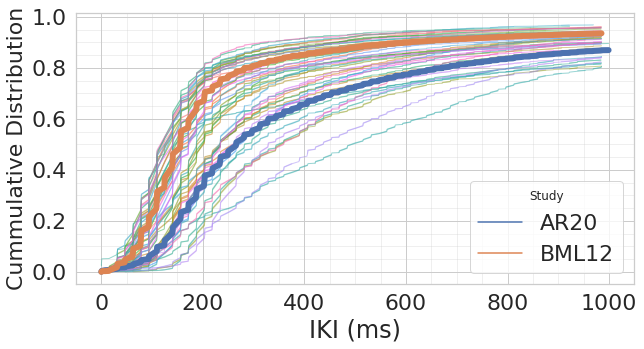

In [74]:
# Plot the figure: this takes a long time!

## set up the figure
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)

# Major X ticks every 200, minor ticks every 50
major_ticks_X = np.arange(0, 2001, 200)
minor_ticks_X = np.arange(0, 2001, 50)

# Major X ticks every 200, minor ticks every 50
minor_ticks_Y = np.arange(0, 1.1, .05)

ax.set_xticks(major_ticks_X)
ax.set_xticks(minor_ticks_X, minor=True)
ax.set_yticks(minor_ticks_Y, minor=True)


# Different settings for the grids:
ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=1)

# Add gridlines
ax.grid(True, which='both')
###############

# plot CDF for all participants
sns.lineplot(data=CumDist, x='IKI', y='Cummulative Distribution', hue='Session', linewidth=1,  alpha=0.5, legend=False)

# plot CDF for study
g = sns.lineplot(data=CumDist[CumDist['Session'].isin(['AR20','BML12'])], x='IKI', 
                 y='Cummulative Distribution', hue='Session',
                 hue_order=['AR20','BML12'], linewidth=6, color=['black','brown'], legend='auto')

plt.xticks(size=22)
plt.yticks(size=22)
sns.move_legend(g, "lower right", fontsize=22)

plt.xlabel("IKI (ms)", size=24)
plt.ylabel('Cummulative Distribution', size=22)



# Percentage of keystroke pauses  < X ms

- per session
- per participant
- per study
- visualization

there is a large variation! 


Text(33.05480833333333, 0.5, 'Proportion of Translators')

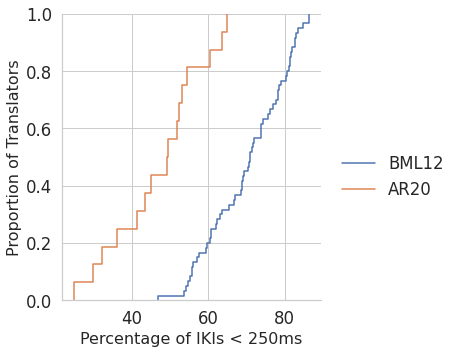

In [951]:
KDdfT = KDdf[(KDdf["Task"] == "T")]

# percentage of pauses < 250 ms

L = {}
Sessions = set(KDdfT['Session'])
for p in Sessions:
    KDdf9 = KDdfT[KDdfT['Session'] == p]
    MP250 = KDdf9[KDdf9['Pause'] < 250]
    
    TL = list(KDdf9['Study'])[0]
    L.setdefault(TL, {})
    L[TL][p] = 100*len(MP250) / len(KDdf9)

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

sns.displot(data=pd.DataFrame(L), kind='ecdf')

# Add labels and a legend
plt.xlabel('Percentage of IKIs < 250ms', size=16)
plt.ylabel('Proportion of Translators', size=16)


# Compute Lags, Respites, Pauses per Participant

Compute a table in which each row represents a participant and the columns have values for:

Median duration of IKIs per participant:

- WWa: median IKI within word per participant (after keystroke)
- WWb: median IKI within word per participant (before keystroke)
- BWa: median IKI between words per participant (after keystroke)
- BWb: median IKI between words per participant (before keystroke)
- BSb: median IKI between segments per participant (before keystroke)

Duration of breaks per participant:
- R: duration of Respite (2 * WWb)
- P: duration of TSF-Pause (3 * BWb)
- S: duration of Segment

Number of breaks per participant:
- : number of Lags 
- NR: number of Respites
- NP: number of TSF-Pauses
- NS: number of Segments

Normalised version of breaks per 100 keystrokes:
- nL: number of Lags
- nR: number of Respites
- nP: number of TSF-Pauses
- nS: number of Segments

Normalised version of breaks per 100 keystrokes:
- keyL: keystrokes per Lag
- keyR: keystrokes per Respite
- keyP: keystrokes per TSF-Pause
- keyS: keystrokes per Segment


In [155]:

# Compute word Boundaries
def tokenBoundaries(DF):
    # shift entire columns one up or down
    DF["NextChar"] = DF["Char"].shift(-1)
    DF["PrevChar"] = DF["Char"].shift(1)
    DF["PrevTTseg"] = DF["TTseg"].shift(1)
    DF["NextTTseg"] = DF["TTseg"].shift(-1)
    DF["PrevSession"] = DF["Session"].shift(1)
    DF["NextSession"] = DF["Session"].shift(-1)

    # Initialize 'Boundary' value for 'within word'
    DF["Boundary"] = 0

    # Chars that indicate a word boundary 
    WordBoundary = ['_', '.', '!', '?', ':', '"','"','=', '@', '$', '%', '&', '*', '(', ')', '[', ']', '{', '}']
    #WordBoundary = ['_']
    
    # Keystroke itself is WordBoundary (ignore):
    DF.loc[(DF['Char'].isin(WordBoundary)), 'Boundary'] += 512

    # WordBoundary before keystroke of word:
    DF.loc[(DF['PrevChar'].isin(WordBoundary)), 'Boundary'] += 1

    # WordBoundary after keystroke of word:
    DF.loc[(DF['NextChar'].isin(WordBoundary)), 'Boundary'] += 2

    # Segment boundary before keystroke:
    DF.loc[(DF['PrevTTseg'] != DF['TTseg']), 'Boundary'] += 4

    # Segment boundary after keystroke:
    DF.loc[(DF['NextTTseg'] != DF['TTseg']), 'Boundary'] += 8

    # Session boundary before keystroke:
    DF.loc[(DF['PrevSession'] != DF['Session']), 'Boundary'] += 16

    # Session boundary after keystroke:
    DF.loc[(DF['NextSession'] != DF['Session']), 'Boundary'] += 32


# Compute Median pauses 
def pauseMedians(DF):
    P = {}
    
    #####################
    # IKIs
    # Keystroke pauses within word
    P['WWb'] = np.nanmedian(list(DF[DF['Boundary'] == 0]["Pause"]))
    P['WWa'] = np.nanmedian(list(DF[DF['Boundary'] == 0]["NextPause"]))

    # Pauses at WordBoundary before keystroke:
    P['BWb'] = np.nanmedian(list(DF[(DF['Boundary'].isin([1,4,5,16,17,20,21]))]["Pause"]))

    # Pauses at WordBoundary after keystroke:
    P['BWa'] = np.nanmedian(list(DF[DF['Boundary'].isin([2,8,10,32,34,40,42])]["NextPause"]))

    # Pauses at Segment boundary before keystroke
    P['BSb'] = np.nanmedian(list(DF[DF['Boundary'].isin([4,5,16,17,20,21])]["Pause"]))

    # Pauses at Segment boundary after keystroke
#    P['SBa'] = np.nanmedian(DF[DF['Boundary'].isin([8,10,32,34,40,42])]["NextPause"])

    # mean Values

    P['WPb_mean'] = np.nanmean(list(DF[DF['Boundary'] == 0]["Pause"]))
    P['WPb_min'] = np.nanmin(list(DF[DF['Boundary'] == 0]["Pause"]))
    P['WPb_max'] = np.nanmax(list(DF[DF['Boundary'] == 0]["Pause"]))

    # Pauses at WordBoundary before keystroke:
    P['BPb_mean'] = np.nanmean(list(DF[(DF['Boundary'].isin([1,4,5,16,17,20,21]))]["Pause"]))
    P['BPb_min'] = np.nanmin(list(DF[DF['Boundary'].isin([2,8,10,32,34,40,42])]["Pause"]))
    P['BPb_max'] = np.nanmax(list(DF[DF['Boundary'].isin([2,8,10,32,34,40,42])]["Pause"]))
    
    #####################
    # Durations of:
    # Respites
    P['R'] = 2 * P['WWb']

    # TSF-pause  
    P['P'] =  3 * P['BWb']

    # Segment-pause  
    P['S'] = P['BSb']

    #####################
    # Number of Lags
    P['NL'] = len(DF[(DF["Pause"] < 200)])
    
    # Number of Delays
    P['ND'] = len(DF[(DF["Pause"] >= 200) & (DF["Pause"] < P['R'])])
    
    # Number of Respites
    P['NR'] = len(DF[(DF["Pause"] >= P['R']) & (DF["Pause"] < P['P'])])
    P['NRg'] = len(DF[(DF["Pause"] >= P['R'])])

    # Number of TSF-pause  
    P['NP'] = len(DF[(DF["Pause"] >= P['P'])])

    # Number of Segment-pause  
    P['NS'] = len(DF[(DF["Pause"] >= P['S'])])

    #####################
    # n: Number of Pauses per 100 keystrokes: 
    n = len(DF) / 100
    
    # Keystrokes per session / 100
    P['norm'] = n
    
    # Lags per 100 keystrokes
    P['nL'] = P['NL']/n
    
    # Delays per 100 keystrokes
    P['nD'] = P['ND']/n
    
    # Respites per 100 keystrokes
    P['nR'] = P['NR']/n

    # TSF-pause  per 100 keystrokes
    P['nP'] = P['NP']/n
    
    # Segment-pause per 100 keystrokes
    P['nS'] = P['NS']/n
    
    #####################
    # Normalized: Number of keystrokes per pause: 
    k = len(DF) 
    
    # keystrokes per Lag
    P['keyL'] = k/P['NL']

    # keystrokes per Lag
    P['keyD'] = k/P['ND']

    # keystrokes per Respite
    P['keyR'] = k/P['NR']
    P['keyRg'] = k/P['NRg']

    # keystrokes per TSF-pause
    P['keyP'] = k/P['NP']
    
    # keystrokes per Segment-pause
    P['keyS'] = k/P['NS']    

    return P

def partMedians(DF):

    H = {}

    # loop through the sessions, write pause information into file
    for part in set(DF["StudyPart"]):
        df = DF[DF['StudyPart'] == part]
        H[part] = pauseMedians(df)
        
    return H



### Store various IKI thresholds in a DataFrame 'DFpauses' 

In [156]:

# Compute Boundary values
tokenBoundaries(KDdf)

# Compute Pause values for within word and between word IKIs 
KDdf["NextPause"] = KDdf["Pause"].shift(-1).fillna(0).astype(int)

# extract keystrokes of translation sessions
KDdfT = KDdf[(KDdf["Task"] == "T")]

# produce relative pause values per participant
DF = partMedians(KDdfT)

# map into a dataframe and transform 
DFpauses = pd.DataFrame(DF).transpose()

DFpauses.sort_index(inplace=True)

# Add a column Study name and Part: 

# Study: the first letters from the index (Study_Part)
DFpauses['Study'] = [i[:-len("_P01")] for i in list(DFpauses.index)]

# Part: the last letters from the index
DFpauses['Part'] = [i[-len("P01"):] for i in list(DFpauses.index)]


# Set parameters for plotting the table
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

print(np.mean(DFpauses.keyR), np.mean(DFpauses.keyP))
# plot table
DFpauses.head(50)


10.144013691815088 10.502539935329938


,WWb,WWa,BWb,BWa,BSb,WPb_mean,WPb_min,WPb_max,BPb_mean,BPb_min,BPb_max,R,P,S,NL,ND,NR,NRg,NP,NS,norm,nL,nD,nR,nP,nS,keyL,keyD,keyR,keyRg,keyP,keyS,Study,Part
AR20_P01,359.0,344.0,453.0,359.0,3390.0,632.813001,1.0,29547.0,1558.975000,15.0,5937.0,718.0,1359.0,3390.0,391.0,985.0,139.0,276.0,137.0,61.0,16.52,23.668281,59.624697,8.414044,8.292978,3.692494,4.225064,1.677157,11.884892,5.985507,12.058394,27.081967,AR20,P01
AR20_P02,282.0,296.0,758.0,140.0,7500.0,481.577157,1.0,11578.0,1837.583333,31.0,13015.0,564.0,2274.0,7500.0,600.0,562.0,282.0,378.0,96.0,19.0,15.40,38.961039,36.493506,18.311688,6.233766,1.233766,2.566667,2.740214,5.460993,4.074074,16.041667,81.052632,AR20,P02
AR20_P03,453.0,453.0,422.0,335.5,4391.0,728.011601,1.0,26672.0,2872.911538,94.0,5579.0,906.0,1266.0,4391.0,291.0,1413.0,158.0,425.0,267.0,79.0,21.29,13.668389,66.369187,7.421325,12.541099,3.710662,7.316151,1.506723,13.474684,5.009412,7.973783,26.949367,AR20,P03
AR20_P04,250.0,250.0,265.5,156.5,3657.0,438.349727,1.0,30719.0,1533.901961,31.0,7469.0,500.0,796.5,3657.0,894.0,891.0,226.0,470.0,244.0,48.0,22.55,39.645233,39.512195,10.022173,10.820399,2.128603,2.522371,2.530864,9.977876,4.797872,9.241803,46.979167,AR20,P04
AR20_P05,282.0,297.0,687.0,125.0,10274.0,425.836620,1.0,7813.0,3179.135965,31.0,7328.0,564.0,2061.0,10274.0,519.0,627.0,180.0,274.0,94.0,18.0,14.20,36.549296,44.154930,12.676056,6.619718,1.267606,2.736031,2.264753,7.888889,5.182482,15.106383,78.888889,AR20,P05
AR20_P06,313.0,328.0,695.5,281.0,1156.0,607.392445,1.0,38078.0,3913.721239,10.0,30047.0,626.0,2086.5,1156.0,191.0,1074.0,280.0,433.0,153.0,230.0,16.98,11.248528,63.250883,16.489988,9.010601,13.545347,8.890052,1.581006,6.064286,3.921478,11.098039,7.382609,AR20,P06
AR20_P07,281.0,297.0,359.0,250.0,3687.0,540.984169,1.0,15781.0,1368.088889,15.0,2907.0,562.0,1077.0,3687.0,309.0,742.0,177.0,404.0,227.0,58.0,14.55,21.237113,50.996564,12.164948,15.601375,3.986254,4.708738,1.960916,8.220339,3.601485,6.409692,25.086207,AR20,P07
AR20_P08,204.0,219.0,297.0,109.0,5695.0,349.538905,1.0,11937.0,1626.692833,31.0,16422.0,408.0,891.0,5695.0,943.0,608.0,239.0,415.0,176.0,28.0,19.66,47.965412,30.925738,12.156663,8.952187,1.424212,2.084836,3.233553,8.225941,4.737349,11.170455,70.214286,AR20,P08
AR20_P09,234.0,235.0,265.0,219.0,6750.0,445.765112,1.0,24922.0,1421.950166,1.0,8328.0,468.0,795.0,6750.0,789.0,868.0,181.0,456.0,275.0,32.0,21.13,37.340274,41.079035,8.566020,13.014671,1.514434,2.678074,2.434332,11.674033,4.633772,7.683636,66.031250,AR20,P09
AR20_P10,344.0,359.5,297.0,609.0,422.0,759.188725,63.0,14593.0,900.914729,141.0,5891.0,688.0,891.0,422.0,131.0,474.0,36.0,204.0,168.0,347.0,8.09,16.192831,58.590853,4.449938,20.766378,42.892460,6.175573,1.706751,22.472222,3.965686,4.815476,2.331412,AR20,P10


In [157]:
DFpauses[DFpauses['Study'] == 'AR20'].describe()

,WWb,WWa,BWb,BWa,BSb,WPb_mean,WPb_min,WPb_max,BPb_mean,BPb_min,BPb_max,R,P,S,NL,ND,NR,NRg,NP,NS,norm,nL,nD,nR,nP,nS,keyL,keyD,keyR,keyRg,keyP,keyS
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,281.318182,292.613636,429.272727,215.431818,5430.500000,547.312327,6.454545,23512.090909,2191.538672,45.818182,11272.181818,562.636364,1287.818182,5430.500000,568.772727,716.272727,213.136364,405.181818,192.045455,140.954545,16.902273,32.858726,43.146889,12.436591,11.557794,8.584353,3.666690,3.155088,9.133730,4.305995,9.402828,41.477539
std,86.472889,91.929053,172.397501,110.285700,5146.358988,140.307866,16.188553,14404.419391,832.105073,45.754663,8082.941642,172.945779,517.192502,5146.358988,298.077799,300.068592,98.510476,140.401342,67.173179,218.374837,4.509200,12.757501,15.030690,4.269277,3.429842,12.144870,1.871343,3.418731,3.831088,0.802065,2.833703,35.506617
min,156.000000,141.000000,265.000000,109.000000,297.000000,349.538905,0.000000,7813.000000,900.914729,0.000000,2907.000000,312.000000,795.000000,297.000000,131.000000,129.000000,36.000000,204.000000,94.000000,10.000000,8.090000,11.248528,5.586834,4.449938,6.233766,0.795756,1.721849,1.506723,4.474806,2.752086,4.815476,2.331412
25%,234.000000,234.250000,297.000000,144.000000,2570.250000,438.408039,1.000000,12883.000000,1537.194076,15.000000,6007.500000,468.000000,891.000000,2570.250000,301.500000,531.250000,153.500000,296.500000,141.000000,29.000000,14.287500,21.844905,36.919201,9.579608,8.966791,1.446767,2.549302,1.771382,6.763212,3.769597,7.711779,13.330495
50%,273.000000,288.500000,359.250000,195.500000,3672.000000,516.108948,1.000000,21484.500000,2167.049588,31.000000,7680.000000,546.000000,1077.750000,3672.000000,557.500000,697.500000,180.500000,409.500000,188.500000,55.500000,16.505000,35.979998,41.139359,11.980771,11.476393,3.456003,2.779369,2.430767,8.348508,4.019880,8.714550,29.071287
75%,309.000000,328.000000,496.000000,230.250000,7312.500000,631.466864,1.000000,29546.750000,2773.321154,74.250000,15523.000000,618.000000,1488.000000,7312.500000,762.000000,945.000000,269.500000,452.000000,230.750000,157.500000,19.935000,39.227025,56.654916,14.786542,12.967690,7.523764,4.587819,2.709674,10.443297,4.782742,11.152351,69.168527
max,516.000000,563.000000,796.000000,609.000000,23016.000000,886.729965,63.000000,71562.000000,3913.721239,141.000000,30797.000000,1032.000000,2388.000000,23016.000000,1341.000000,1413.000000,516.000000,839.000000,323.000000,961.000000,25.340000,58.077090,66.369187,22.347337,20.766378,42.892460,8.890052,17.899225,22.472222,5.985507,16.041667,125.666667


# Keystroke Bigram Frequency and average  WW IKIs

- compute boundary values
- produce keystroke bigrams
- produce WW pivot table with bigram length, median and  mean pause values


In [8]:
# compute the boundary values
tokenBoundaries(KDdf)

# produce keystroke bigram 
KDdf['BiChar'] = KDdf['PrevChar'] + KDdf['Char']

# length of Char Bigram 
KDdf['BiChar_Len'] = KDdf['BiChar'].str.len()

# insertion/deletion of next keystroke
#KDdf["NextType"] = KDdf["Type"].shift(-1)

# insertion/deletion of previous keystroke
KDdf["PrevType"] = KDdf["Type"].shift(1)

# Within Word bigrams: take out strings (keep only individual keystrokes)
KDbiCharWW = KDdf[(KDdf["Task"] == "T")
             & (KDdf['Boundary'] == 0) # within word
             & (KDdf["BiChar_Len"] < 3) # take out inserions/deletions of strings > 1 char
            ]


# This computes the median, mean and length of bigrams per Participant
pivotBiCharWW = KDbiCharWW.pivot_table(index=['TL','BiChar','Type','PrevType'], columns=['StudyPart'], 
                                    values=['Pause'], aggfunc=[np.nanmedian,np.nanmean,len], margins=True)

pivotBiCharWW


nanmedian                                      \
                             Pause                                       
StudyPart                 AR20_P01 AR20_P02 AR20_P03 AR20_P04 AR20_P05   
TL  BiChar Type PrevType                                                 
ar  ,,     Mdel Mins           NaN      NaN      NaN      NaN      NaN   
    ,0     Mins Mins           NaN      NaN      NaN      NaN      NaN   
    ,1     Mdel Mdel           NaN      NaN      NaN      NaN      NaN   
    ,g     Mins Mins           NaN      NaN    437.0      NaN      NaN   
    ,t     Mins Mdel           NaN      NaN      NaN      NaN      NaN   
...                            ...      ...      ...      ...      ...   
es  ꡟ돇     Mins Mdel           NaN      NaN      NaN      NaN      NaN   
    돇돇     Mdel Mins           NaN      NaN      NaN      NaN      NaN   
    t     Mins Mdel           NaN      NaN      NaN      NaN      NaN   
         Mdel Mins           NaN      NaN      NaN      NaN      NaN   
All                          359.0    282.0    438.0    250.0    282.0   

                                                                       \
                                                                        
StudyPart                AR20_P06 AR20_P07 AR20_P08 AR20_P09 AR20_P10   
TL  BiChar Type PrevType                                                
ar  ,,     Mdel Mins        735.0      NaN      NaN      NaN      NaN   
    ,0     Mins Mins          NaN      NaN      NaN      NaN      NaN   
    ,1     Mdel Mdel          NaN      NaN      NaN      NaN      NaN   
    ,g     Mins Mins          NaN      NaN      NaN      NaN      NaN   
    ,t     Mins Mdel        906.0      NaN      NaN      NaN      NaN   
...                           ...      ...      ...      ...      ...   
es  ꡟ돇     Mins Mdel          NaN      NaN      NaN      NaN      NaN   
    돇돇     Mdel Mins          NaN      NaN      NaN      NaN      NaN   
    t     Mins Mdel          NaN      NaN      NaN      NaN      NaN   
         Mdel Mins          NaN      NaN      NaN      NaN      NaN   
All                         312.0    281.0    204.0    234.0    344.0   

                                                                       \
                                                                        
StudyPart                AR20_P11 AR20_P12 AR20_P13 AR20_P14 AR20_P15   
TL  BiChar Type PrevType                                                
ar  ,,     Mdel Mins          NaN      NaN      NaN      NaN      NaN   
    ,0     Mins Mins          NaN      NaN      NaN      NaN      NaN   
    ,1     Mdel Mdel          NaN      NaN      NaN      NaN      NaN   
    ,g     Mins Mins          NaN      NaN      NaN      NaN      NaN   
    ,t     Mins Mdel          NaN      NaN      NaN      NaN      NaN   
...                           ...      ...      ...      ...      ...   
es  ꡟ돇     Mins Mdel          NaN      NaN      NaN      NaN      NaN   
    돇돇     Mdel Mins          NaN      NaN      NaN      NaN      NaN   
    t     Mins Mdel          NaN      NaN      NaN      NaN      NaN   
         Mdel Mins          NaN      NaN      NaN      NaN      NaN   
All                         235.0    296.0    219.0    297.0    219.0   

                                                                       \
                                                                        
StudyPart                AR20_P16 AR20_P17 AR20_P18 AR20_P19 AR20_P20   
TL  BiChar Type PrevType                                                
ar  ,,     Mdel Mins          NaN      NaN      NaN      NaN      NaN   
    ,0     Mins Mins        656.0      NaN      NaN      NaN      NaN   
    ,1     Mdel Mdel        140.0      NaN      NaN      NaN      NaN   
    ,g     Mins Mins          NaN      NaN      NaN      NaN      NaN   
    ,t     Mins Mdel          NaN      NaN      NaN      NaN      NaN   
...                           ...      ...      ...      ...     

## Compare Mean and Median WW, BW IKIs and TPS, Respites

- compute mean, median for within word (WW) between word (BW), Respites, Pauses

In [780]:

# compute mean BW pauses
KDdfB = KDdf[(KDdf["Task"] == "T")
             & (KDdf['Boundary'].isin([1,4,5,16,17,20,21])) 
             & (KDdf["BiChar_Len"] < 3) # take out inserions/deletions of strings 
            ]

# This computes the median, mean and length of bigrams per Participant
pivotBW = KDdfB.pivot_table(index=['TL','BiChar'], columns='StudyPart', 
                                               values=['Pause'], aggfunc=[np.nanmedian,np.nanmean, len], margins=True)


# MEAN of mean WW IKI per Part
def medianMeanRespites(STUDY) :
    
    print("Mean/Median/Respites/Pauses and STD for:", STUDY)
    # take out margin row 'All'
    m1 = pivotBiCharWW.loc[:, 'nanmean']['Pause'].loc['All',:]
    # only the Arabic column
    m2 = m1.loc[:,m1.columns.str.contains(STUDY)]
    # get the mean values 
    m3 = np.array(list(m2.iloc[0,:-1]))
    print(f"Mean of mean WW  \t{m3.mean():4.2f}\t{m3.std():4.2f}")


    # MEAN of median WW IKI per Part 
    DFar = DFpauses[DFpauses.index.str.startswith(STUDY)]
    print(f"Mean of median WW\t{DFar['WWb'].mean():4.2f}\t{DFar['WWb'].std():4.2f}") 


    # MEAN of mean WW IKI per Part
    m1 = pivotBW.loc[:, 'nanmean']['Pause'].loc['All',:]
    # only the Arabic column
    m2 = m1.loc[:,m1.columns.str.contains(STUDY)]
    # get the mean values 
    m3 = np.array(list(m2.iloc[0,:-1]))
    print(f"Mean of mean BW  \t{m3.mean():4.2f}\t{m3.std():4.2f}")


    # MEAN of median BW IKI per Part 
    print(f"Mean of median BW\t{DFar['BWb'].mean():4.2f}\t{DFar['BWb'].std():4.2f}")

    # MEAN of respites over all Part 
    print(f"Mean of respites \t{DFar['R'].mean():4.2f}\t{DFar['R'].std():4.2f}")  

    # MEAN of pauses over all Part 
    print(f"Mean of pauses  \t{DFar['P'].mean():4.2f}\t{DFar['P'].std():4.2f}")


medianMeanRespites("AR20")
medianMeanRespites("BML12")

Mean/Median/Respites/Pauses and STD for: AR20
Mean of mean WW  	532.83	133.01
Mean of median WW	281.32	86.47
Mean of mean BW  	1928.37	698.42
Mean of median BW	429.27	172.40
Mean of respites 	562.64	172.95
Mean of pauses  	1287.82	517.19
Mean/Median/Respites/Pauses and STD for: BML12
Mean of mean WW  	270.45	79.38
Mean of median WW	150.28	29.09
Mean of mean BW  	1271.82	532.05
Mean of median BW	232.27	95.58
Mean of respites 	300.56	58.19
Mean of pauses  	696.80	286.74


### Plot Bigram Frequency and average  WW IKIs

"(IKIs) are shorter within highly frequent bigrams" 

- take out outliers and plot results
- different results for insertions and deletions


Spearman correlation Arabic:0.55 p:0.000521
Spearman correlation Spanish:0.41 p:0.006818


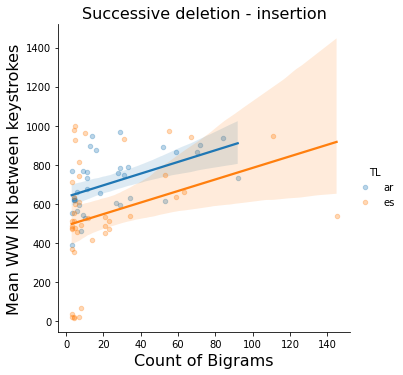

In [10]:
# take out strings (keep only individual keystrokes)
KDbiChar = KDdf[(KDdf["Task"] == "T")
#             & (KDdf['Boundary'] == 0) # within word
             & (KDdf["BiChar_Len"] < 3) # take out inserions/deletions of strings > 1 char
            ]


# This computes the median, mean and length of bigrams per Participant
pivotBiChar = KDbiChar.pivot_table(index=['TL','BiChar','Type','PrevType'], columns=['Study'], 
                                    values=['Pause'], aggfunc=[np.nanmedian,np.nanmean,len], margins=True)


# Take out columns of interest 
M = list(pivotBiChar.loc[:, 'nanmedian']['Pause']['All'])
N = list(pivotBiChar.loc[:, 'nanmean']['Pause']['All'])
L = list(pivotBiChar.loc[:, 'len']['Pause']['All'])
C = list(pivotBiChar.reset_index()['BiChar'])
T = list(pivotBiChar.reset_index()['TL'])
A = list(pivotBiChar.reset_index()['Type'])
B = list(pivotBiChar.reset_index()['PrevType'])

# produce dataframe
DFBiChar = pd.DataFrame({'BiChar' : C, 'Count':L, 'Median':M, 'Mean':N, 'TL': T, "Type1": A, 'Type2': B}) 

# take out outliers (by eye)
df1 = DFBiChar[
          (DFBiChar.Type1 == 'Mdel') 
        & (DFBiChar.Type2 == 'Mins') 
        & (DFBiChar.Count < 300) 
        & (DFBiChar.Mean  < 1000) 
        & (DFBiChar.Count > 2) # minimum of 2 instances 
        ]


# Plot Pause distributions 
sns.lmplot(x='Count', y='Mean', data = df1, hue='TL',
          scatter_kws = {"alpha": 0.3, 's':20}
          )

# Add labels and a legend
plt.title('Successive deletion - insertion', size=16)
plt.xlabel('Count of Bigrams', size=16)
plt.ylabel('Mean WW IKI between keystrokes', size=16)


# Correlation coefficient
r, p = scipy.stats.spearmanr(df1[df1['TL'] == 'ar']['Count'],
                             df1[df1['TL'] == 'ar']['Mean'])
print(f"Spearman correlation Arabic:{r:4.2f} p:{p:4.6f}")

# Correlation coefficient
r, p = scipy.stats.spearmanr(df1[df1['TL'] == 'es']['Count'],
                             df1[df1['TL'] == 'es']['Mean'])
print(f"Spearman correlation Spanish:{r:4.2f} p:{p:4.6f}")

Spearman correlation Arabic:-0.08 p:0.064311
Spearman correlation Spanish:-0.18 p:0.000204


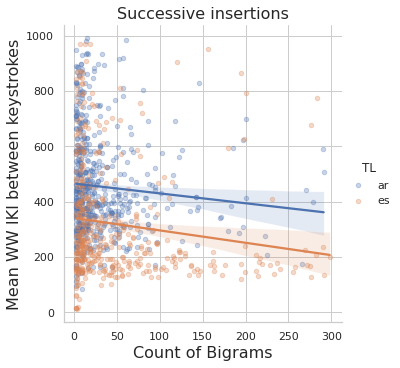

In [130]:
# take out outliers (by eye)
df1 = DFBiChar[
          (DFBiChar.Type1 == 'Mins') 
        & (DFBiChar.Type2 == 'Mins') 
        & (DFBiChar.Count < 300) 
        & (DFBiChar.Mean  < 1000) 
        & (DFBiChar.Count > 2) # minimum of 2 instances 
        ]


# Plot Pause distributions 
sns.lmplot(x='Count', y='Mean', data = df1, hue='TL',
          scatter_kws = {"alpha": 0.3, 's':20}
          )

# Add labels and a legend
plt.title('Successive insertions', size=16)
plt.xlabel('Count of Bigrams', size=16)
plt.ylabel('Mean WW IKI between keystrokes', size=16)


# Correlation coefficient
r, p = scipy.stats.spearmanr(df1[df1['TL'] == 'ar']['Count'],
                             df1[df1['TL'] == 'ar']['Mean'])
print(f"Spearman correlation Arabic:{r:4.2f} p:{p:4.6f}")

# Correlation coefficient
r, p = scipy.stats.spearmanr(df1[df1['TL'] == 'es']['Count'],
                             df1[df1['TL'] == 'es']['Mean'])
print(f"Spearman correlation Spanish:{r:4.2f} p:{p:4.6f}")

# WW IKIs during from-scratch translation and post-editing 
Munoz: "overall IKI means are stable across tasks": 

In [957]:
# take out strings / keep only individual keystrokes 
KDdfWW = KDdf[(KDdf["Task"].isin(['T','P']))
             & (KDdf['Boundary'] == 0) # within word
             & (KDdf["BiChar_Len"] < 3) # take out inserions/deletions of strings > 1 char
            ]

# This computes the median, mean and length of bigrams per Participant
pivotPT = KDdfWW.pivot_table(index=['TL','Task','BiChar'], columns=['StudyPart'], 
                                               values=['Pause'], aggfunc=[np.nanmedian,np.nanmean, len], margins=True)


# Take out columns of interest 
M = list(pivotPT.loc[:, 'nanmedian']['Pause']['All'])
N = list(pivotPT.loc[:, 'nanmean']['Pause']['All'])
L = list(pivotPT.loc[:, 'len']['Pause']['All'])
C = list(pivotPT.reset_index()['BiChar'])
T = list(pivotPT.reset_index()['TL'])
K = list(pivotPT.reset_index()['Task'])

# produce dataframe
dfPT = pd.DataFrame({'BiChar' : C, 'Count':L, 'Median':M, 'Mean':N, 'TL': T, 'Task': K}) 

dfPT.head()

,BiChar,Count,Median,Mean,TL,Task
0,",,",8,812.5,1359.250000,ar,P
1,",d",3,0.0,47.000000,ar,P
2,",s",3,531.0,515.333333,ar,P
3,",t",1,0.0,0.000000,ar,P
4,",ؤ",1,1422.0,1422.000000,ar,P


BML12_P16:	P / T are different:	p:0.0168, mean pause T:1103.04 pause P:266.34
BML12_P28:	P / T are different:	p:0.0264, mean pause T:477.43 pause P:183.71
BML12_P09:	P / T are different:	p:0.0338, mean pause T:1573.95 pause P:257.75
AR20_P08:	P / T are different:	p:0.0242, mean pause T:1137.63 pause P:349.54
AR20_P21:	P / T are the same:	p:0.1329, mean pause T:686.38 pause P:558.00
BML12_P11:	P / T are different:	p:0.0430, mean pause T:786.49 pause P:201.19
BML12_P29:	P / T are different:	p:0.0001, mean pause T:327.95 pause P:253.54
AR20_P10:	P / T are the same:	p:0.4020, mean pause T:604.86 pause P:759.19
AR20_P04:	P / T are the same:	p:0.6987, mean pause T:774.18 pause P:438.35
AR20_P18:	P / T are different:	p:0.0008, mean pause T:1005.76 pause P:688.72
AR20_P22:	P / T are different:	p:0.0251, mean pause T:1120.05 pause P:479.45
BML12_P25:	P / T are the same:	p:0.1929, mean pause T:972.45 pause P:219.20
BML12_P15:	P / T are the same:	p:0.0613, mean pause T:3178.10 pause P:245.84
BML1

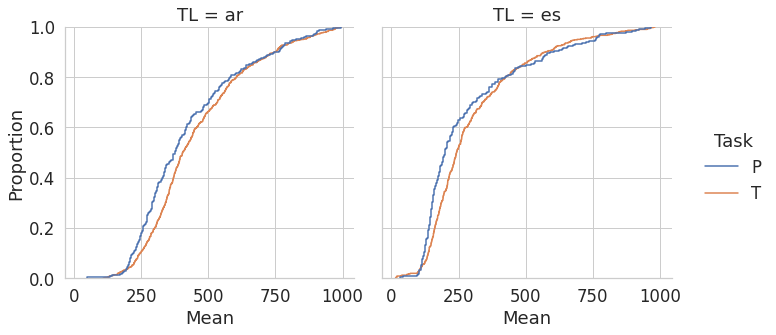

In [958]:
# take out outliers (by eye)
df1 = dfPT[(dfPT.Count < 800)  # maximum of 5 instances  
         & (dfPT.Count > 2) # minimum of 5 instances 
         & (dfPT.Mean  < 1000) 
        ]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Plot Pause distributions 
sns.displot(x='Mean', data = df1, kind='ecdf', hue='Task',col='TL', height=5, aspect=1 )
        

same = 0 
diff = 0
for part in set(KDdf['StudyPart']):
    dfS1 = KDdf[(KDdf['StudyPart'] == part) & (KDdf['Task'] == 'P')]
    dfS2 = KDdf[(KDdf['StudyPart'] == part) & (KDdf['Task'] == 'T')]
    
    if(len(dfS1) >0 and  len(dfS2) >0) :
        sample1 = list(dfS1[dfS1['Boundary'] == 0]['Pause'])
        sample2 = list(dfS2[dfS2['Boundary'] == 0]['Pause'])
        ks_statistic, p_value = scipy.stats.ks_2samp(sample1, sample2)

        # mean of the two samples
        m1 = np.mean(sample1)
        m2 = np.mean(sample2)

        # Compare the p-value to the significance level
        significance_level = 0.05

        if p_value > significance_level:
            same += 1
            print(f"{part}:\tP / T are the same:\tp:{p_value:4.4f}, mean pause T:{m1:4.2f} pause P:{m2:4.2f}")
        else:
            diff += 1
            print(f"{part}:\tP / T are different:\tp:{p_value:4.4f}, mean pause T:{m1:4.2f} pause P:{m2:4.2f}")

print("same:", same, "different:", diff)

In [773]:
# Similarity of Translations from different translators

same = 0 
diff = 0

#for part1 in sorted(set(KDdfTcopy['StudyPart'])):
#    dfS1 = KDdfTcopy[(KDdfTcopy['StudyPart'] == part1) & (KDdfTcopy['Task'] == 'T')]
for part1 in sorted(set(KDdfT['StudyPart'])):
    dfS1 = KDdfT[(KDdfT['StudyPart'] == part1) & (KDdfT['Task'] == 'T')]

    
#    for part2 in sorted(set(KDdfTcopy['StudyPart'])):
    for part2 in sorted(set(KDdfT['StudyPart'])):
        if (part1 == part2) : continue
                                               
#        dfS2 = KDdfTcopy[(KDdfTcopy['StudyPart'] == part2) & (KDdfTcopy['Task'] == 'T')]
        dfS2 = KDdfT[(KDdfT['StudyPart'] == part2) & (KDdfT['Task'] == 'T')]
        if(len(dfS1) >0 and  len(dfS2) >0) :
            sample1 = list(dfS1[dfS1['Boundary'] == 0]['Pause'])
            sample2 = list(dfS2[dfS2['Boundary'] == 0]['Pause'])
            ks_statistic, p_value = scipy.stats.ks_2samp(sample1, sample2)

            # mean of the two samples
            m1 = np.mean(sample1)
            m2 = np.mean(sample2)

            # Compare the p-value to the significance level
            significance_level = 0.05

            if p_value > significance_level:
                same += 1
                print(f"{part1}/{part2}:\tP / T are the same:\tp:{p_value:4.4f}, mean pause T:{m1:4.2f} pause P:{m2:4.2f}")
            else:
                diff += 1
#                print(f"{part1}/{part2}:\tP / T are different:\tp:{p_value:4.4f}, mean pause T:{m1:4.2f} pause P:{m2:4.2f}")

print("same:", same, "different:", diff)

AR20_P04/AR20_P11:	P / T are the same:	p:0.8387, mean pause T:438.35 pause P:491.23
AR20_P05/AR20_P12:	P / T are the same:	p:0.6289, mean pause T:425.84 pause P:438.58
AR20_P06/AR20_P10:	P / T are the same:	p:0.1932, mean pause T:607.39 pause P:759.19
AR20_P07/AR20_P14:	P / T are the same:	p:0.0600, mean pause T:540.98 pause P:886.73
AR20_P07/AR20_P20:	P / T are the same:	p:0.4405, mean pause T:540.98 pause P:608.18
AR20_P08/AR20_P13:	P / T are the same:	p:0.1100, mean pause T:349.54 pause P:416.36
AR20_P08/AR20_P15:	P / T are the same:	p:0.1890, mean pause T:349.54 pause P:424.80
AR20_P09/AR20_P11:	P / T are the same:	p:0.0645, mean pause T:445.77 pause P:491.23
AR20_P09/AR20_P13:	P / T are the same:	p:0.1139, mean pause T:445.77 pause P:416.36
AR20_P09/AR20_P22:	P / T are the same:	p:0.5709, mean pause T:445.77 pause P:479.45
AR20_P10/AR20_P06:	P / T are the same:	p:0.1932, mean pause T:759.19 pause P:607.39
AR20_P10/AR20_P19:	P / T are the same:	p:0.3744, mean pause T:759.19 pause P

BML12_P29/BML12_P26:	P / T are the same:	p:0.1588, mean pause T:253.54 pause P:251.68
BML12_P29/BML12_P27:	P / T are the same:	p:0.1944, mean pause T:253.54 pause P:277.65
BML12_P30/BML12_P17:	P / T are the same:	p:0.1013, mean pause T:312.36 pause P:397.93
BML12_P31/BML12_P05:	P / T are the same:	p:0.0627, mean pause T:426.84 pause P:426.47
BML12_P32/BML12_P01:	P / T are the same:	p:0.5932, mean pause T:373.71 pause P:222.62
BML12_P32/BML12_P03:	P / T are the same:	p:0.9921, mean pause T:373.71 pause P:211.78
BML12_P32/BML12_P06:	P / T are the same:	p:0.0956, mean pause T:373.71 pause P:261.96
BML12_P32/BML12_P09:	P / T are the same:	p:0.5197, mean pause T:373.71 pause P:257.75
BML12_P32/BML12_P10:	P / T are the same:	p:0.5238, mean pause T:373.71 pause P:227.17
BML12_P32/BML12_P12:	P / T are the same:	p:0.5598, mean pause T:373.71 pause P:226.05
BML12_P32/BML12_P22:	P / T are the same:	p:0.1046, mean pause T:373.71 pause P:211.66
BML12_P32/BML12_P23:	P / T are the same:	p:0.0504, mea

In [756]:
# Similarity of IKI Distribution across different translation sessions of same translator

same = 0
diff = 0
for part in set(KDdf['StudyPart']):
    s = part[-3:]
    sess = list(set(KDdf[(KDdf['Task'] == 'T') & (KDdf['StudyPart'] == part)]['Session']))
    if(len(sess) == 2) :
        sample1 = list(KDdf[(KDdf['StudyPart'] == part) & 
                            (KDdf['Boundary'] == 0) &
                            (KDdf['Session'] == sess[0])]['Pause'])
        sample2 = list(KDdf[(KDdf['StudyPart'] == part) & 
                             (KDdf['Boundary'] == 0) &
                             (KDdf['Session'] == sess[1])]['Pause'])
        ks_statistic, p_value = scipy.stats.ks_2samp(sample1, sample2)

        # mean of the two samples
        m1 = np.mean(sample1)
        m2 = np.mean(sample2)

        # Compare the p-value to the significance level
        significance_level = 0.05

        if p_value > significance_level:
            print(f"{part}:\t{sess[0]} / {sess[1]} are the same:\tp:{p_value:4.4f}, mean pause T:{m1:4.2f} pause P:{m2:4.2f}")
            same += 1
        else:
            print(f"{part}:\t{sess[0]} / {sess[1]} are different:\tp:{p_value:4.4f}, mean pause T:{m1:4.2f} pause P:{m2:4.2f}")
            diff += 1

print("Translation same:", same, "different:", diff)

BML12_P23:	P23_T1 / P23_T2 are the same:	p:0.5646, mean pause T:176.36 pause P:359.58
AR20_P05:	P05_T4 / P05_T3 are the same:	p:0.2649, mean pause T:404.51 pause P:442.56
AR20_P11:	P11_T3 / P11_T4 are the same:	p:0.8338, mean pause T:542.90 pause P:393.64
BML12_P28:	P28_T6 / P28_T5 are the same:	p:0.9029, mean pause T:210.72 pause P:161.52
BML12_P06:	P06_T5 / P06_T6 are the same:	p:0.3530, mean pause T:275.38 pause P:251.30
BML12_P15:	P15_T6 / P15_T4 are different:	p:0.0008, mean pause T:205.62 pause P:292.45
AR20_P06:	P06_T5 / P06_T6 are the same:	p:0.9094, mean pause T:655.15 pause P:542.22
BML12_P08:	P08_T3 / P08_T5 are the same:	p:0.7161, mean pause T:577.55 pause P:389.28
AR20_P07:	P07_T1 / P07_T2 are the same:	p:0.0550, mean pause T:607.07 pause P:486.94
AR20_P02:	P02_T3 / P02_T4 are different:	p:0.0463, mean pause T:489.57 pause P:471.14
BML12_P27:	P27_T4 / P27_T3 are different:	p:0.0067, mean pause T:290.72 pause P:268.86
AR20_P15:	P15_T5 / P15_T6 are the same:	p:0.4652, mean p

## Relation of IKIs Within Word (WW) / Between Word  (BW) --- Respites / TSF-Pauses

- bring DFpauses into long format
- add columns for Study and Part 
- plot relation WW / BW - 
- plot relation Respites / Pauses

In [37]:

# bring into long format
DFpauses1 = pd.melt(DFpauses, id_vars=['Study','Part'], value_vars=['WWb','BWb','R', 'P'], var_name="Pause", value_name='IKI')
DFpauses1.head()


,Study,Part,Pause,IKI
0,AR20,P01,WWb,359.0
1,AR20,P02,WWb,282.0
2,AR20,P03,WWb,453.0
3,AR20,P04,WWb,250.0
4,AR20,P05,WWb,282.0


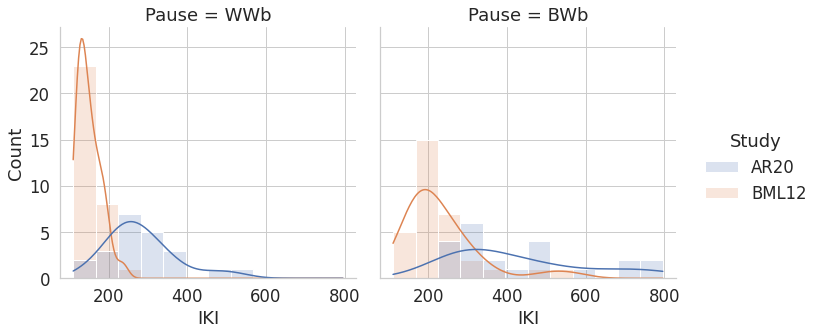

In [38]:

# Plot Pause distributions for WW and 
sns.displot(DFpauses1[DFpauses1['Pause'].isin(['WWb','BWb'])], x='IKI', kde=True, alpha=0.2, hue='Study', col='Pause', aspect = 1)


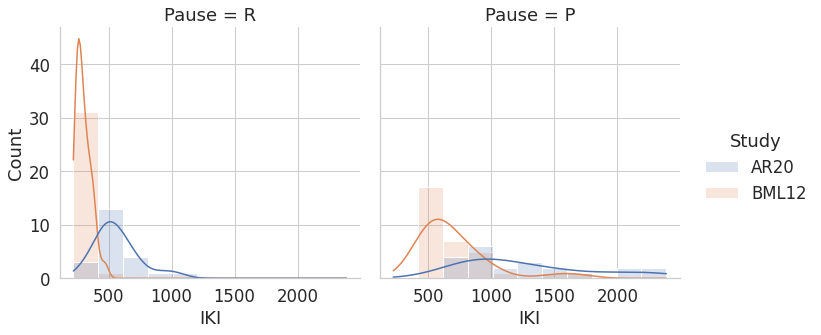

In [39]:
# Plot Pause distributions 
sns.displot(DFpauses1[DFpauses1['Pause'].isin(['R','P'])], x='IKI', kde=True, alpha=0.2, hue='Study', col='Pause', aspect = 1)


Spearman correlation Arabic:0.40 p:0.064940
Spearman correlation Spanish:0.68 p:0.000017


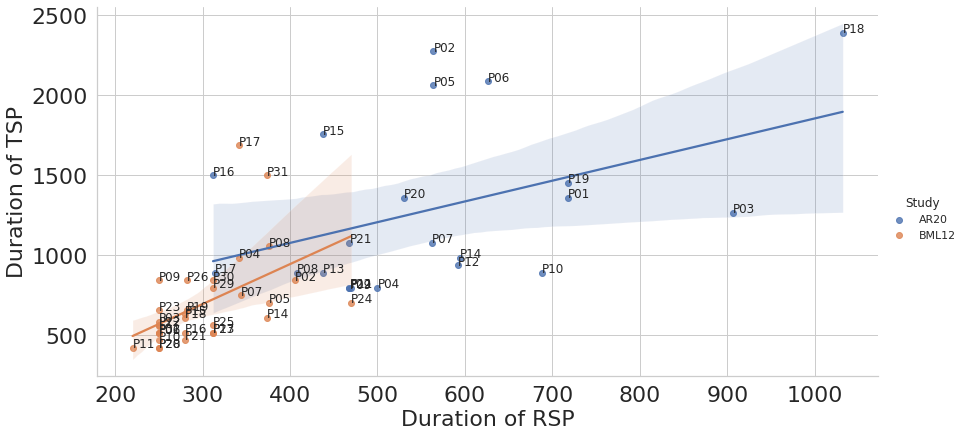

In [444]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

sns.lmplot(data=DFpauses, x='R', y='P', hue='Study', height=6, aspect=2)

for index, row in DFpauses.iterrows():
    plt.annotate(row['Part'], (float(row['R']), float(row['P'])))
    
    
# Add labels and a legend
#plt.title('Relative number of Respites vs. number of Pauses for 100 keystrokes', size=16)

plt.xlabel('Duration of RSP', size=22)
plt.ylabel('Duration of TSP', size=22)
plt.yticks(size=22)
plt.xticks(size=22)

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'AR20']['R'],
                             DFpauses[DFpauses['Study'] == 'AR20']['P'])
print(f"Spearman correlation Arabic:{r:4.2f} p:{p:4.6f}")

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'BML12']['R'],
                             DFpauses[DFpauses['Study'] == 'BML12']['P'])
print(f"Spearman correlation Spanish:{r:4.2f} p:{p:4.6f}")



In [763]:
DFpauses.head()

,WWb,WWa,BWb,BWa,BSb,WPb_mean,WPb_min,WPb_max,BPb_mean,BPb_min,BPb_max,R,P,S,NL,ND,NR,NRg,NP,NS,norm,nL,nD,nR,nP,nS,keyL,keyD,keyR,keyRg,keyP,keyS,Study,Part,taskPseg
AR20_P01,359.0,344.0,453.0,359.0,3390.0,632.813001,1.0,29547.0,1558.975000,15.0,5937.0,718.0,1359.0,3390.0,391.0,985.0,139.0,276.0,137.0,61.0,16.52,23.668281,59.624697,8.414044,8.292978,3.692494,4.225064,1.677157,11.884892,5.985507,12.058394,27.081967,AR20,P01,2.014599
AR20_P02,282.0,296.0,758.0,140.0,7500.0,481.577157,1.0,11578.0,1837.583333,31.0,13015.0,564.0,2274.0,7500.0,600.0,562.0,282.0,378.0,96.0,19.0,15.40,38.961039,36.493506,18.311688,6.233766,1.233766,2.566667,2.740214,5.460993,4.074074,16.041667,81.052632,AR20,P02,3.937500
AR20_P03,453.0,453.0,422.0,335.5,4391.0,728.011601,1.0,26672.0,2872.911538,94.0,5579.0,906.0,1266.0,4391.0,291.0,1413.0,158.0,425.0,267.0,79.0,21.29,13.668389,66.369187,7.421325,12.541099,3.710662,7.316151,1.506723,13.474684,5.009412,7.973783,26.949367,AR20,P03,1.591760
AR20_P04,250.0,250.0,265.5,156.5,3657.0,438.349727,1.0,30719.0,1533.901961,31.0,7469.0,500.0,796.5,3657.0,894.0,891.0,226.0,470.0,244.0,48.0,22.55,39.645233,39.512195,10.022173,10.820399,2.128603,2.522371,2.530864,9.977876,4.797872,9.241803,46.979167,AR20,P04,1.926230
AR20_P05,282.0,297.0,687.0,125.0,10274.0,425.836620,1.0,7813.0,3179.135965,31.0,7328.0,564.0,2061.0,10274.0,519.0,627.0,180.0,274.0,94.0,18.0,14.20,36.549296,44.154930,12.676056,6.619718,1.267606,2.736031,2.264753,7.888889,5.182482,15.106383,78.888889,AR20,P05,2.914894


Spearman correlation Arabic:0.56 p:0.006707
Spearman correlation Spanish:-0.10 p:0.575330


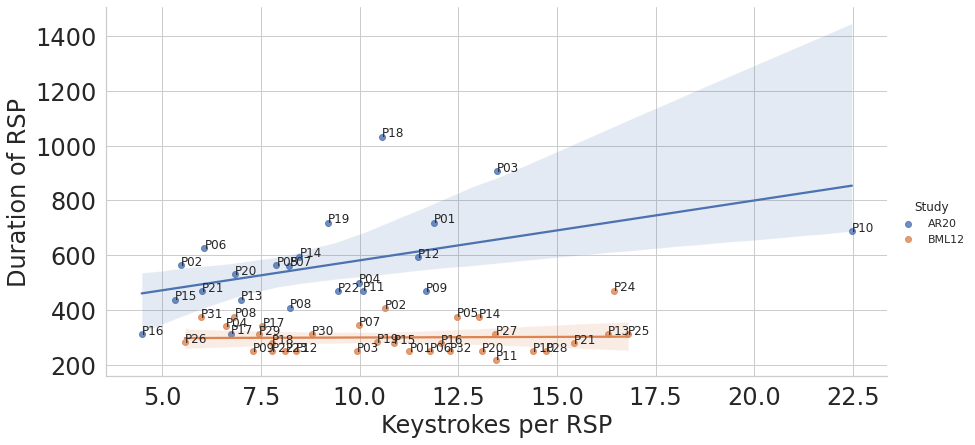

In [502]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

sns.lmplot(data=DFpauses, x='keyR', y='R', hue='Study', height=6, aspect=2)
#sns.regplot(data=DFpauses, x='keyP', y='keyR', lowess=True)

for index, row in DFpauses.iterrows():
    plt.annotate(row['Part'], (float(row['keyR']), float(row['R'])))
    
    
# Add labels and a legend
#plt.title('Relative number of Respites vs. number of Pauses for 100 keystrokes', size=16)

plt.xlabel('Keystrokes per RSP', size=24)
plt.ylabel('Duration of RSP', size=24)
plt.yticks(size=24)
plt.xticks(size=24)

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'AR20']['R'],
                             DFpauses[DFpauses['Study'] == 'AR20']['keyR'])
print(f"Spearman correlation Arabic:{r:4.2f} p:{p:4.6f}")

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'BML12']['R'],
                             DFpauses[DFpauses['Study'] == 'BML12']['keyR'])
print(f"Spearman correlation Spanish:{r:4.2f} p:{p:4.6f}")



Spearman correlation Arabic:-0.26 p:0.235716
Spearman correlation Spanish:-0.38 p:0.031333


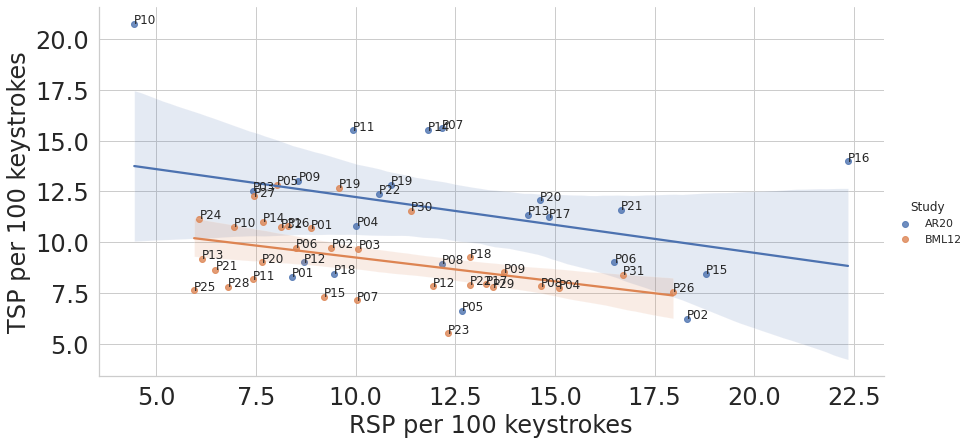

In [446]:
# Plot Pause distributions 
sns.set(font_scale=1)
sns.set_style("whitegrid")

sns.lmplot(data=DFpauses, x='nR', y='nP', hue='Study', height=6, aspect=2)

for index, row in DFpauses.iterrows():
    plt.annotate(row['Part'], (float(row['nR']), float(row['nP'])))
    
    
# Add labels and a legend
#plt.title('Relative number of Respites vs. number of Pauses for 100 keystrokes', size=16)

plt.xlabel('RSP per 100 keystrokes', size=24)
plt.ylabel('TSP per 100 keystrokes', size=24)
plt.xticks(size=24)
plt.yticks(size=24)

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'AR20']['nR'],
                             DFpauses[DFpauses['Study'] == 'AR20']['nP'])
print(f"Spearman correlation Arabic:{r:4.2f} p:{p:4.6f}")

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'BML12']['nR'],
                             DFpauses[DFpauses['Study'] == 'BML12']['nP'])
print(f"Spearman correlation Spanish:{r:4.2f} p:{p:4.6f}")



Spearman correlation Arabic:-0.18 p:0.410735
Spearman correlation Spanish:-0.52 p:0.002394


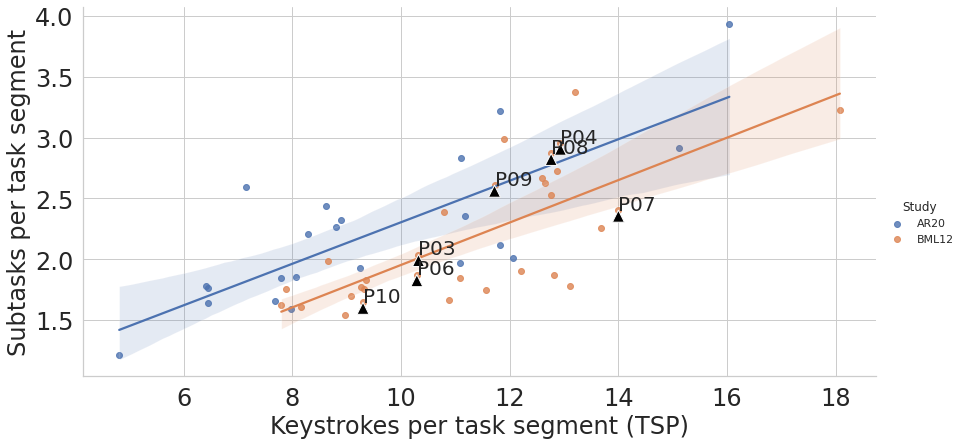

In [769]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
'''
"AR20-P02_T4-Ali.csv"
,"AR20-P04_T1-Sabrin.csv"
,"AR20-P08_T3-Sabrin.csv"
,"AR20-P08_T4-Sabrin.csv"
,"AR20-P09_T6-Sabrin.csv"
,"AR20-P17_T4-Sabrin.csv"
,"BML12-P03_T6-Takanori+R.csv"
,"BML12-P04_T1-Takanori+R.csv"
,"BML12-P04_T2-Ali.csv"
,"BML12-P06_T5-Takanori+R.csv"
,"BML12-P07_T3-Takanori+R.csv"
,"BML12-P08_T5-Takanori+R.csv"
,"BML12-P09_T1-Takanori+Rcsv"
,"BML12-P10_T4-Takanori+R.csv"
'''

#Fpauses['taskPseg'] = DFpauses['keyP'] / DFpauses['keyRg']
DFpauses['taskPseg'] = DFpauses['NRg'] / DFpauses['NP']

# Plot Pause distributions 
g = sns.lmplot(data=DFpauses, y='taskPseg', x='keyP', hue='Study', height=6, aspect=2)

for index, row in DFpauses.iterrows():
#    plt.annotate(row['Part'], (float(row['keyRg']), float(row['keyP'])))
    if((row['Study'] == 'BML12' and row['Part'] == 'P03') or
       (row['Study'] == 'BML12' and row['Part'] == 'P04') or
       (row['Study'] == 'BML12' and row['Part'] == 'P06') or
       (row['Study'] == 'BML12' and row['Part'] == 'P07') or
       (row['Study'] == 'BML12' and row['Part'] == 'P08') or
       (row['Study'] == 'BML12' and row['Part'] == 'P09') or 
       (row['Study'] == 'BML12' and row['Part'] == 'P10')
      ): 
        plt.annotate(row['Part'], (float(row['keyP']), float(row['taskPseg'])), size=15,
            arrowprops=dict(facecolor='black', shrink=1.5))
       
#    plt.annotate(row['Part'], (float(row['keyP']), float(row['taskPseg'])))
    
    
# Add labels and a legend
#plt.title('Relative number of Respites vs. number of Pauses for 100 keystrokes', size=16)

#sns.move_legend(g, "upper right", fontsize=24)

plt.xlabel('Keystrokes per task segment (TSP)', size=24)
#plt.xlabel('Keystrokes per Task segment (TSP)', size=24)
plt.ylabel('Subtasks per task segment', size=24)

plt.xticks(size=24)
plt.yticks(size=24)

#Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'AR20']['keyRg'],
                             DFpauses[DFpauses['Study'] == 'AR20']['taskPseg'])
print(f"Spearman correlation Arabic:{r:4.2f} p:{p:4.6f}")

# Correlation coefficient
r, p = scipy.stats.spearmanr(DFpauses[DFpauses['Study'] == 'BML12']['keyRg'],
                             DFpauses[DFpauses['Study'] == 'BML12']['taskPseg'])
print(f"Spearman correlation Spanish:{r:4.2f} p:{p:4.6f}")

#Spearman correlation Arabic:-0.26 p:0.235716
#Spearman correlation Spanish:-0.38 p:0.031333


In [214]:
#KDdfTcopy = KDdf[(KDdf["Task"] == "T")].copy()
#
#set(KDdfTcopy['State'])
KDdf.head()

,Id,Study,Session,SL,TL,Task,Text,Part,Time,Pause,Border,Type,Cur,Char,TTseg,STid,SGid,TTid,Strokes,Dur,EdStr,LsDist,Draft,DistCur,DistTTid,StudyPart,NextChar,PrevChar,PrevTTseg,NextTTseg,PrevSession,NextSession,Boundary,NextPause,BiChar,BiChar_Len,PrevType,State
0,1,BML12,P01_E5,en,es,E,5,P01,114139,114139,7,Mdel,142,Incrementar_,3,25,25,24,12,0,0,0,0,11,0,BML12_P01,E,NaN,NaN,3.0,NaN,P01_E5,20,1,NaN,NaN,NaN,---
1,2,BML12,P01_E5,en,es,E,5,P01,114140,1,0,Mins,131,E,3,25,25,24,1,0,0,0,0,1,0,BML12_P01,l,Incrementar_,3.0,3.0,P01_E5,P01_E5,0,203,Incrementar_E,13.0,Mdel,---
2,3,BML12,P01_E5,en,es,E,5,P01,114343,203,0,Mins,132,l,3,25,25,24,1,0,0,0,0,1,0,BML12_P01,_,E,3.0,3.0,P01_E5,P01_E5,2,94,El,2.0,Mins,---
3,4,BML12,P01_E5,en,es,E,5,P01,114437,94,0,Mins,133,_,3,25,25,24,1,0,0,0,0,1,1,BML12_P01,i,l,3.0,3.0,P01_E5,P01_E5,512,156,l_,2.0,Mins,---
4,5,BML12,P01_E5,en,es,E,5,P01,114593,156,1,Mins,134,i,3,25,25,25,1,0,0,0,0,1,0,BML12_P01,n,_,3.0,3.0,P01_E5,P01_E5,1,110,_i,2.0,Mins,---


# Fluent Typing: Subtasks : ADD, DEL, CHANGE
Munoz & Apfelthaler: "no respites in fluent ADD task segments"

- compute fluent segments for all participants:
    1. ADD: segment has only additions
    2. DEL: segment has only deletions
    2. CHANGE: segment has additions and deletions
- produce bar plot 

In [1240]:
# TASK SEGMENTS
KDdfTcopy = KDdf[(KDdf["State"] != "---")].copy()
KDdfTcopy['SegTask'] = '---'

# return dictionalry with fluent segments
TaskSegments = {}

# compute segments of fluent typing per participant
for sp in sorted(set(KDdfTcopy['StudyPart'])) :
    SP = KDdfTcopy[KDdfTcopy.StudyPart == sp]
    TSP = DFpauses['P'][sp] 
    I = D =  0 # number of Insertions and deletions
    string = '' # segment of fluent production
    pauses = [] # list of pauses
    types = '' # segment of fluent production
    start = 0
    end = 0
    sess = ''
    taskId = 0
    

#    print(f"{p}\tkeystrokens:{len(P)}\tRespite:{m}")
    for index, row in SP.iterrows():

        # save segment if IKI > pespite for the participant
        if((row['Pause'] >= TSP or row.Session != sess) and sess != '') :
            
            l = len(string)
            Length.setdefault(sp, {})
            Length[sp].setdefault(l, 0)
            Length[sp][l] += 1
            Length[sp][l] += 1
            
            TaskSegments.setdefault(sp,{})
            TaskSegments[sp].setdefault(taskId,{})
            TaskSegments[sp][taskId]['s'] = string
            TaskSegments[sp][taskId]['p'] = pauses
            TaskSegments[sp][taskId]['t'] = types
            
            string = ''
            pauses = []
            types = ''
            start = end = I = D = 0
            #start = row['Time']

        sess = row.Session
        string += str(row['Char'])
        
        if(start == 0): 
            start = row['Time']
            # memorize the 
            TaskSegments.setdefault(sp, {})
            TaskSegments[sp].setdefault(taskId,{})
            TaskSegments[sp][taskId]['r'] = row['Pause']
            taskId += 1
#            if(TSPid != taskId): print(TSPid, taskId)
        else: 
            pauses.append(row['Pause'])
            
        end = row['Time']

        if(row['Type'] == 'Mdel') : 
            D +=1
            types += 'D'
        elif(row['Type'] == 'Mins') : 
            I +=1
            types += 'I'
        elif(row['Type'] != 'Sins') : print("Type unknown", row['Type'])

TaskSegments


{'AR20_P02': {0: {'r': 16859},
  1: {'s': 'fhgghf', 'p': [172, 125, 672, 156, 141], 't': 'IIIDDD', 'r': 5141},
  2: {'s': 'بالرععغم_من_أن_',
   'p': [140,
    188,
    1250,
    219,
    515,
    297,
    844,
    140,
    1454,
    125,
    140,
    766,
    187,
    203],
   't': 'IIIIIDIIIIIIIII',
   'r': 3875},
  3: {'s': 'الدول_النامية_',
   'p': [157, 140, 532, 125, 78, 187, 110, 312, 188, 375, 156, 140, 110],
   't': 'IIIIIIIIIIIIII',
   'r': 11859},
  4: {'s': 'لا_', 'p': [125, 125], 't': 'III', 'r': 3391},
  5: {'s': 'ت', 'p': [], 't': 'I', 'r': 3109},
  6: {'s': 'تمنى_', 'p': [625, 188, 265, 125], 't': 'IIIII', 'r': 3813},
  7: {'s': '_أن_', 'p': [750, 140, 157], 't': 'IIII', 'r': 2734},
  8: {'s': 'تقوم_بأي_تنازلات_',
   'p': [203,
    453,
    360,
    140,
    360,
    281,
    172,
    109,
    344,
    109,
    188,
    640,
    204,
    328,
    218,
    235],
   't': 'IIIIIIIIIIIIIIIII',
   'r': 2859},
  9: {'s': 'ب', 'p': [], 't': 'I', 'r': 2297},
  10: {'s': 'بلأي_فر

In [1253]:
Respites = DFpauses['R']

# take out strings / keep only individual keystrokes 

#KDdfTcopy = KDdf.copy()

KDdfTcopy = KDdf[(KDdf["State"] != "---")].copy()
KDdfTcopy['SegTask'] = '---'

# return dictionalry with fluent segments
Fluent = {}
Length = {}
Tasks = {}


# compute segments of fluent typing per participant
for sp in sorted(set(KDdfTcopy['StudyPart'])) :
    SP = KDdfTcopy[KDdfTcopy.StudyPart == sp]
    RSP = Respites[sp] 
    I = D =  0 # number of Insertions and deletions
    string = '' # segment of fluent production
    pauses = [] # list of pauses
    types = '' # segment of fluent production
    start = 0
    end = 0
    sess = ''
    taskId = 0
    

#    print(f"{p}\tkeystrokens:{len(P)}\tRespite:{m}")
    for index, row in SP.iterrows():

        # save segment if IKI > pespite for the participant
        if((row['Pause'] >= RSP or row.Session != sess) and sess != '') :
#        if((row['Pause'] >= RSP or row.Session != sess) 
#           and string != ''):
            
            l = len(string)
            Length.setdefault(sp, {})
            Length[sp].setdefault(l, 0)
            Length[sp][l] += 1
            Length[sp][l] += 1
            
            Tasks.setdefault(sp,{})
            Tasks[sp].setdefault(taskId,{})
            Tasks[sp][taskId]['s'] = string
            Tasks[sp][taskId]['p'] = pauses
            Tasks[sp][taskId]['t'] = types
#            taskId += 1
            
            Fluent.setdefault(sp,{})
            Fluent[sp].setdefault(string, 0)
            Fluent[sp][string] += 1

            Fluent.setdefault('Total', {})
            Fluent['Total'].setdefault(string,0)
            Fluent['Total'][string] += 1
            
            Fluent.setdefault('len',{})
            Fluent['len'].setdefault(string,0)
            Fluent['len'][string] = l
            
            Fluent.setdefault('TL',{})
            Fluent['TL'].setdefault(string,0)
            Fluent['TL'][string] = row['TL']
            
            Fluent.setdefault('Type',{})
            Fluent['Type'].setdefault(string,'')
            
            SegTask = '---'
            if(D == 0) : SegTask = 'ADD'
            elif(I == 0) : SegTask = 'DEL'
            else : SegTask = 'CHANGE'
                
            Fluent['Type'][string] = SegTask
            KDdfTcopy.loc[(KDdfTcopy.StudyPart == sp) &
                          (KDdfTcopy.Time >= start) & 
                          (KDdfTcopy.Time <= end), 
                          'SegTask']  = SegTask
            
            KDdfTcopy.loc[(KDdfTcopy.StudyPart == sp) &
                          (KDdfTcopy['Time'] == start), 'SegTask']  = f'{SegTask}_B'
            
            Fluent.setdefault('INS',{})
            Fluent.setdefault('DEL',{})
            Fluent['INS'][string] = I
            Fluent['DEL'][string] = D
            
            state = row['State']
            Fluent.setdefault(state,{})
            Fluent[state].setdefault(string, 0)
            Fluent[state][string] += 1
            
            Fluent.setdefault('FlTotDur',{})
            Fluent['FlTotDur'].setdefault(string, 0)
            Fluent['FlTotDur'][string] += end - start
            
            string = ''
            pauses = []
            types = ''
            start = end = I = D = 0
            #start = row['Time']

        sess = row.Session
        string += str(row['Char'])
        
        if(start == 0): 
            start = row['Time']
            # memorize the 
            Tasks.setdefault(sp, {})
            Tasks[sp].setdefault(taskId,{})
            Tasks[sp][taskId]['r'] = row['Pause']
            taskId += 1
#            if(TSPid != taskId): print(TSPid, taskId)
        else: 
            pauses.append(row['Pause'])
            
        end = row['Time']

        if(row['Type'] == 'Mdel') : 
            D +=1
            types += 'D'
        elif(row['Type'] == 'Mins') : 
            I +=1
            types += 'I'
        elif(row['Type'] != 'Sins') : print("Type unknown", row['Type'])


    
FlLength = pd.DataFrame(Length)
P = {}
for p in FlLength.columns:
    P[sp] = np.array(FlLength[sp]) / np.nansum(FlLength[sp])

FlProbs = pd.DataFrame(P).fillna(0)


FlAddDel = pd.DataFrame.from_dict(Fluent)
FlAddDel['FlDur'] = FlAddDel['FlTotDur'] / FlAddDel['Total']

print(np.mean(FlAddDel.len), np.mean(np.array(FlAddDel['len']) * np.array(FlAddDel['Total'])))
FlAddDel.head(10)

6.754735308402137 7.627003399708596


,AR20_P02,Total,len,TL,Type,INS,DEL,F,FlTotDur,H,O,AR20_P04,R,AR20_P08,AR20_P09,AR20_P17,BML12_P03,BML12_P04,BML12_P06,BML12_P07,BML12_P08,BML12_P09,BML12_P10,FlDur
fhg,1.0,1,3,ar,ADD,3,0,1.0,297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.000000
ghf,1.0,1,3,ar,DEL,0,3,1.0,297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.000000
بال,1.0,2,3,ar,ADD,3,0,1.0,594,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,297.000000
رععغ,1.0,1,4,ar,CHANGE,3,1,1.0,1031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1031.000000
م_,1.0,3,2,ar,ADD,2,0,3.0,311,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.666667
من_,2.0,2,3,ar,ADD,3,0,2.0,499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.500000
أن_,4.0,6,3,ar,ADD,3,0,4.0,2405,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.833333
الدول_النامية_,1.0,1,14,ar,ADD,14,0,NaN,2610,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2610.000000
لا_,2.0,3,3,ar,DEL,0,3,2.0,984,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.000000
ت,3.0,13,1,ar,ADD,1,0,9.0,0,3.0,1.0,1.0,NaN,4.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [1208]:
H = {}
r = 20
for study in Tasks:
    V = [0] * r
    D = [0] * r
    for i in Tasks[study]:
        if('p' not in Tasks[study][i]) : 
#            print(i, study )
            continue
        for j, k in enumerate(Tasks[study][i]['p']):
            if(k == 0) : break
            if(j >= r) : break
            V[j] += k
            D[j] += 1
    M = [0] * r
    for j in range(r): 
        if(D[j] > 0): M[j] = V[j] / D[j]

    m = sum(V)
    for j in range(r): 
        if(D[j] > 0): M[j] /= m
    H[study] = M


In [1254]:
#N = pd.DataFrame(H)
#sns.lineplot(data=N)


In [189]:
FlAddDel['LogDur'] = np.log(FlAddDel['FlTotDur'] + 1)


# map dictionary into DataFrame
col = ['BML12_P23', 'BML12_P24', 'BML12_P25', 'BML12_P26']
val = ['len', 'LogDur','Type', 'TL']
FlAddDelLong = pd.melt(FlAddDel, id_vars=val, value_vars=col, var_name="Session", value_name='OCC')
FlAddDelLong[(FlAddDelLong.OCC.notnull())].head()


,len,LogDur,Type,TL,Session,OCC
9,1,0.000000,ADD,es,BML12_P23,41.0
68,1,0.000000,ADD,es,BML12_P23,2.0
161,2,10.551402,ADD,es,BML12_P23,4.0
960,2,7.458186,ADD,es,BML12_P23,1.0
1373,1,0.000000,ADD,es,BML12_P23,2.0


In [774]:
F = {}
for sp in set(KDdfTcopy['StudyPart']) :
    v = [0]*5
    v[0] = np.mean(FlAddDel[(FlAddDel[sp].notnull())]['len'])
    v[1] = np.mean(FlAddDel[(FlAddDel[sp].notnull())]['INS'])
    v[2] = np.mean(FlAddDel[(FlAddDel[sp].notnull())]['DEL'])
    v[3] = np.mean(FlAddDel[(FlAddDel[sp].notnull())]['FlDur'])
    v[4] = list(FlAddDel[(FlAddDel[sp].notnull())]['TL'])[0]
    F[sp] = v

F1 = pd.DataFrame(F).transpose()
F1.columns = ['Len','INS','DEL', 'Dur', 'TL']
#F2 = pd.melt(F1, id_vars=val, value_vars=col, var_name="Session", value_name='OCC')

F1.head()

,Len,INS,DEL,Dur,TL
AR20_P08,6.12987,5.02922,0.75974,876.077,ar
BML12_P06,6.14623,4.96698,0.759434,560.42,es
BML12_P10,7.61842,6.23026,0.532895,666.024,es
BML12_P07,6.4104,5.89017,0.421965,840.073,es
BML12_P08,5.71687,5.15663,0.439759,814.543,es


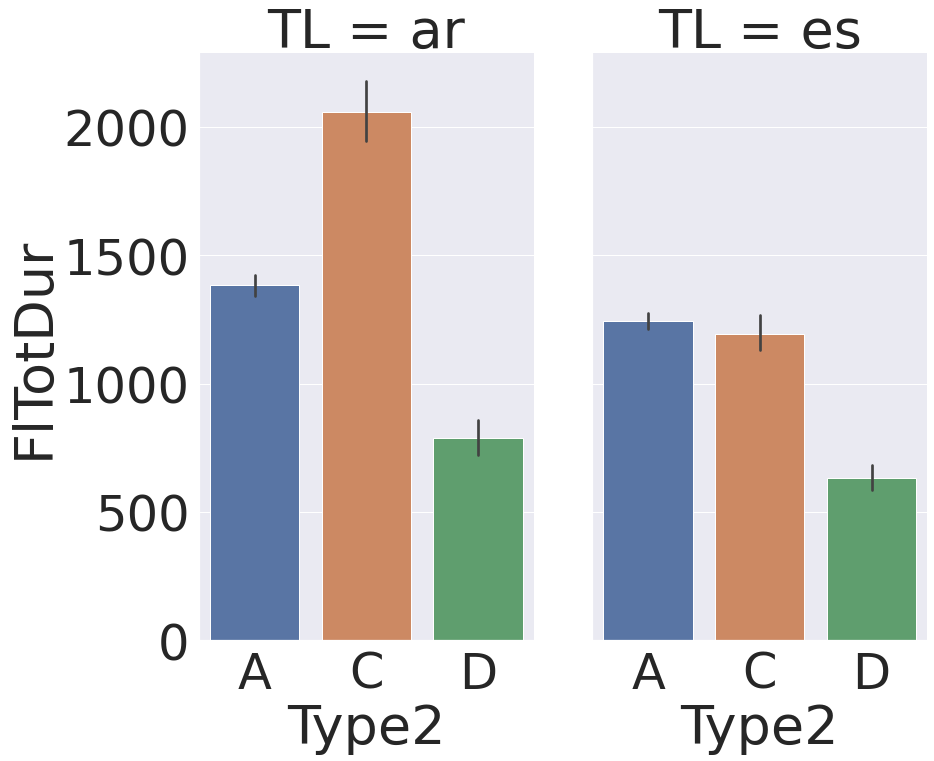

In [20]:
FlAddDel['Type2'] = FlAddDel.Type.replace(['ADD', 'DEL','CHANGE'], ['A', 'D','C'])

sns.set(font_scale=4.5)
sns.catplot(x="Type2",
            y="FlTotDur",
#            y="len",
            kind="bar",
            data=FlAddDel,
            col = 'TL',
            height=12,
            aspect=0.6
        )



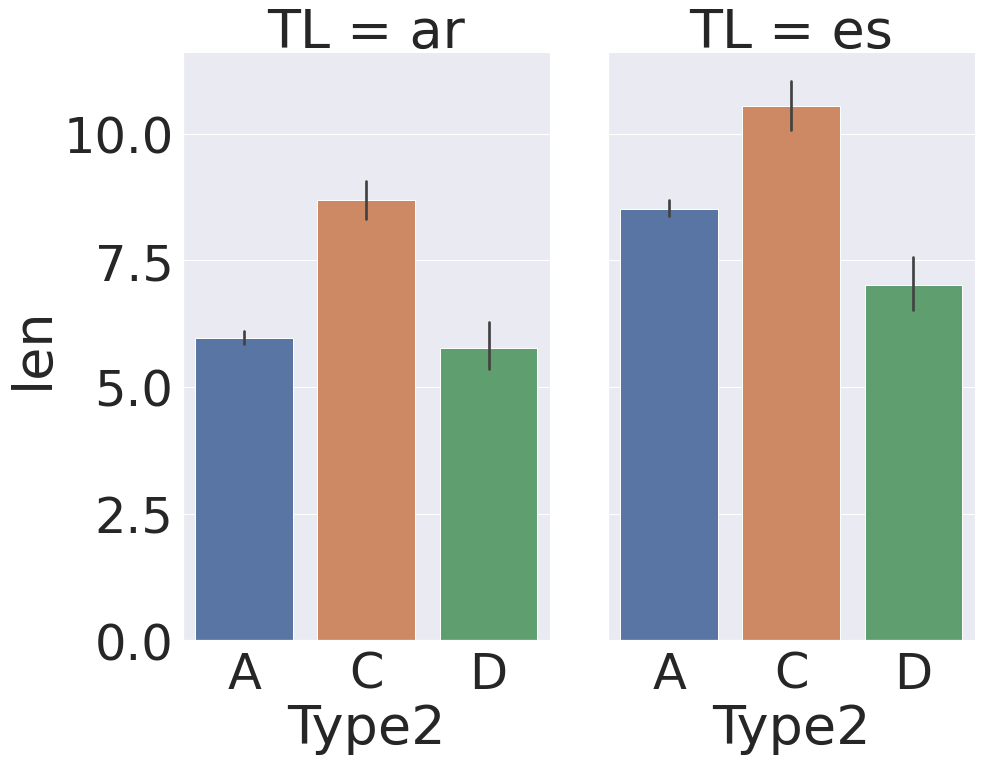

In [1052]:
FlAddDel['Type2'] = FlAddDel.Type.replace(['ADD', 'DEL','CHANGE'], ['A', 'D','C'])

sns.set(font_scale=4.5)
sns.catplot(x="Type2",
            y="len",
            kind="bar",
            data=FlAddDel,
            col = 'TL',
            height=12,
            aspect=0.6
        )


#plt.ylabel('Keystrokes per RSP', size=24)
#plt.xlabel('Keystrokes per RSP', size=24)

#plt.xticks(size=24)
#plt.yticks(size=24)


ADD Mean INS:7.53--5.45
ADD Mean DEL:0.00--0.00
ADD Mean Dur:1103.73--928.71
ADD Median INS:6.00
ADD Median DEL:0.00
ADD Median Dur:859.12
DEL Mean INS:0.00--0.00
DEL Mean DEL:5.30--5.06
DEL Mean Dur:580.69--514.57
DEL Median INS:0.00
DEL Median DEL:4.00
DEL Median Dur:454.00
CHANGE Mean INS:6.59--5.81
CHANGE Mean DEL:2.20--2.18
CHANGE Mean Dur:1594.03--1671.15
CHANGE Median INS:5.00
CHANGE Median DEL:1.00
CHANGE Median Dur:1109.00


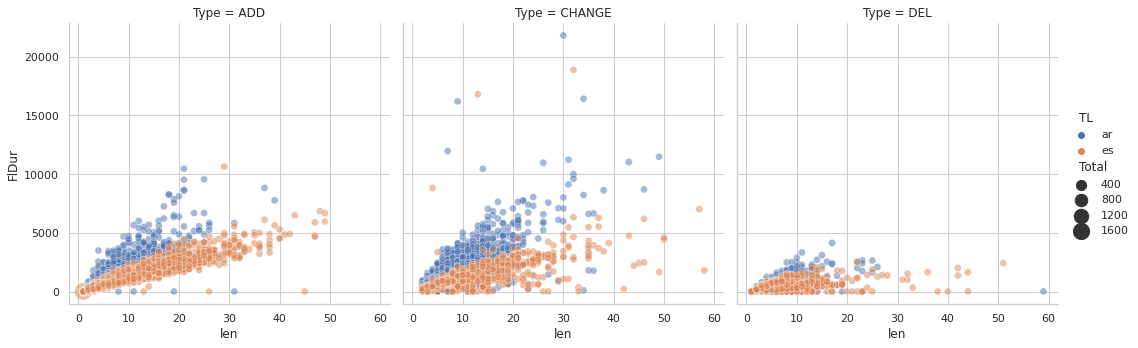

In [743]:
# Number of insertions and deletions per CHANGE

#D = FlAddDel[FlAddDel['Type'] == "CHANGE"]
sns.relplot(data=FlAddDel[(FlAddDel.len < 60)], x="len", y="FlDur", hue="TL", col='Type', size='Total', sizes=(50, 300), alpha=.5)
for m in ['ADD', 'DEL', 'CHANGE']:
    print(f"{m} Mean INS:{np.mean(FlAddDel[FlAddDel.Type == m].INS):4.2f}--{np.std(FlAddDel[FlAddDel.Type == m].INS):4.2f}")
    print(f"{m} Mean DEL:{np.mean(FlAddDel[FlAddDel.Type == m].DEL):4.2f}--{np.std(FlAddDel[FlAddDel.Type == m].DEL):4.2f}")
    print(f"{m} Mean Dur:{np.mean(FlAddDel[FlAddDel.Type == m].FlDur):4.2f}--{np.std(FlAddDel[FlAddDel.Type == m].FlDur):4.2f}")

    print(f"{m} Median INS:{np.median(FlAddDel[FlAddDel.Type == m].INS):4.2f}")
    print(f"{m} Median DEL:{np.median(FlAddDel[FlAddDel.Type == m].DEL):4.2f}")
    print(f"{m} Median Dur:{np.median(FlAddDel[FlAddDel.Type == m].FlDur):4.2f}")

#sns.rugplot(data=D, x="INS", y="DEL", lw=1.5, alpha=.5)


## Pauses and fluent typing bursts (ADD, DEL, CHANGE) per participant

- mean length of fluent typing burst 
- total number of fluent typing bursts
- percentage of keystroke in bursts (per 100 keystrokes)


In [32]:
# Merge average typing data into Pause Table 

H = {}
for p in list(set(KDdf.StudyPart)):
    
    for t in set(FlAddDel.Type):
        l = f'{t}_len'  # mean length of fluent typing burst 
        m = f'{t}_mean' # mean number of fluent typing bursts
        k = f'{t}_sum'  # sum of operations
        o = f'{t}_perc' # burst per 100 keystrokes
     
        H.setdefault(l,{})
        H.setdefault(k,{})
        H.setdefault(o,{})
        
        # get length for every typing burst (per Type) and multiply by number of occurances (== total number of keys)
        M = np.array(FlAddDel[(FlAddDel.Type == t) & (FlAddDel[p].notnull())]['len']) * \
            np.array(FlAddDel[(FlAddDel.Type == t) & (FlAddDel[p].notnull())][p]) 
        
        # divide sum of total keystroke number by normalization factor
        H[o][p] = sum(M) / DFpauses.loc[p,'norm']
        
        # total number of bursts
        H[k][p] = np.nansum(list(FlAddDel[FlAddDel.Type == t][p]))
        
        # mean length of burst 
        H[l][p] = np.nanmean(list(FlAddDel[(FlAddDel.Type == t) & (FlAddDel[p].notnull())]['len']))

#        H.setdefault(m,{})
#        H[m][p] = np.nanmean(list(FlAddDel[FlAddDel.Type == t][p]))
    
DF_ADC = pd.DataFrame(H)

DF_ADC = DF_ADC.join(DFpauses, how='outer')
DF_ADC.head()

,ADD_len,ADD_sum,ADD_perc,CHANGE_len,CHANGE_sum,CHANGE_perc,DEL_len,DEL_sum,DEL_perc,WWb,WWa,BWb,BWa,BSb,R,P,S,NL,ND,NR,NP,NS,norm,nL,nD,nR,nP,nS,keyL,keyD,keyR,keyP,keyS,Study,Part
AR20_P01,2.838235,110.0,14.830508,9.877698,139.0,83.111380,3.133333,26.0,3.510896,359.0,344.0,453.0,359.0,3390.0,718.0,1359.0,3390.0,391.0,985.0,139.0,137.0,61.0,16.52,23.668281,59.624697,8.414044,8.292978,3.692494,4.225064,1.677157,11.884892,12.058394,27.081967,AR20,P01
AR20_P02,4.880184,302.0,78.181818,6.343750,33.0,13.311688,4.074074,42.0,8.441558,282.0,296.0,758.0,140.0,7500.0,564.0,2274.0,7500.0,600.0,562.0,282.0,96.0,19.0,15.40,38.961039,36.493506,18.311688,6.233766,1.233766,2.566667,2.740214,5.460993,16.041667,81.052632,AR20,P02
AR20_P03,3.801370,211.0,30.577736,8.258824,182.0,67.073744,3.380952,31.0,3.804603,453.0,453.0,422.0,335.5,4391.0,906.0,1266.0,4391.0,291.0,1413.0,158.0,267.0,79.0,21.29,13.668389,66.369187,7.421325,12.541099,3.710662,7.316151,1.506723,13.474684,7.973783,26.949367,AR20,P03
AR20_P04,5.191111,311.0,56.940133,9.032609,94.0,37.028825,4.707317,64.0,9.711752,250.0,250.0,265.5,156.5,3657.0,500.0,796.5,3657.0,894.0,891.0,226.0,244.0,48.0,22.55,39.645233,39.512195,10.022173,10.820399,2.128603,2.522371,2.530864,9.977876,9.241803,46.979167,AR20,P04
AR20_P05,6.041667,242.0,88.943662,9.000000,8.0,5.070423,4.666667,23.0,6.619718,282.0,297.0,687.0,125.0,10274.0,564.0,2061.0,10274.0,519.0,627.0,180.0,94.0,18.0,14.20,36.549296,44.154930,12.676056,6.619718,1.267606,2.736031,2.264753,7.888889,15.106383,78.888889,AR20,P05


In [510]:
#[r.CHANGE_perc + r.DEL_perc + r.ADD_perc for i, r in DF_ADC.iterrows()]
#np.mean((DF_ADC.CHANGE_perc + DF_ADC.DEL_perc + DF_ADC.ADD_perc))


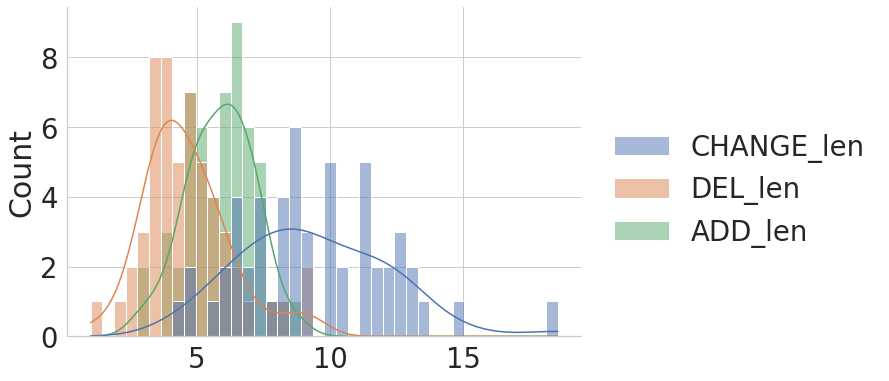

In [498]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")

sns.displot(data=DF_ADC[['CHANGE_len','DEL_len','ADD_len','Study']], kde=True, bins=40, height=6, aspect=1.5 )

Text(0.5, 8.959999999999994, 'Percentage of keystrokes in typing burst')

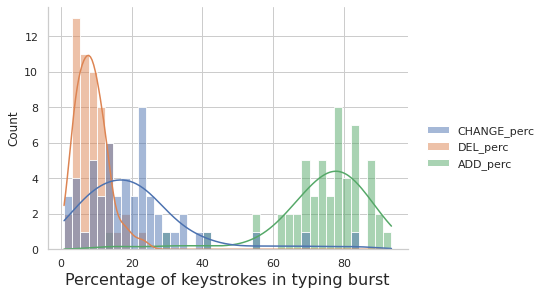

In [415]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

#sns.relplot(data=DF_ADC, x='nR', y='nP', hue='Study', size='ADD_perc', sizes=(2, 400), height=6, aspect=2)
sns.displot(data=DF_ADC[['CHANGE_perc','DEL_perc','ADD_perc']], kde=True, bins=40, height=4, aspect=1.5)

plt.xlabel('Percentage of keystrokes in typing burst', size=16)
plt.ylabel('Length of typing burst', size=16)


## Automatized Typing Patterns (Motor Program)

Munoz & Apfelthaler:Sequences separated by delays are slightly longer than mean (WW) IKIs
- "slightly longer" we take it to be 10%

In [151]:
Study = 'BML12'

# get the Margin line 'All' for Mean values per participant
m = pivotBiCharWW.loc[:, 'nanmean']['Pause'].loc['All',:]

# keep only mean WW values for <Study>
m1 = m.loc[:,m.columns.str.contains(Study)]

# get the mean values for WW
aa = np.array(list(m1.iloc[0,:]))
aa
m1
m
DFpauses.head()

,WWb,WWa,BWb,BWa,BSb,R,P,S,NL,ND,NR,NRg,NP,NS,norm,nL,nD,nR,nP,nS,keyL,keyD,keyR,keyRg,keyP,keyS,Study,Part
AR20_P01,359.0,344.0,453.0,359.0,3390.0,718.0,1359.0,3390.0,391.0,985.0,139.0,276.0,137.0,61.0,16.52,23.668281,59.624697,8.414044,8.292978,3.692494,4.225064,1.677157,11.884892,5.985507,12.058394,27.081967,AR20,P01
AR20_P02,282.0,296.0,758.0,140.0,7500.0,564.0,2274.0,7500.0,600.0,562.0,282.0,378.0,96.0,19.0,15.40,38.961039,36.493506,18.311688,6.233766,1.233766,2.566667,2.740214,5.460993,4.074074,16.041667,81.052632,AR20,P02
AR20_P03,453.0,453.0,422.0,335.5,4391.0,906.0,1266.0,4391.0,291.0,1413.0,158.0,425.0,267.0,79.0,21.29,13.668389,66.369187,7.421325,12.541099,3.710662,7.316151,1.506723,13.474684,5.009412,7.973783,26.949367,AR20,P03
AR20_P04,250.0,250.0,265.5,156.5,3657.0,500.0,796.5,3657.0,894.0,891.0,226.0,470.0,244.0,48.0,22.55,39.645233,39.512195,10.022173,10.820399,2.128603,2.522371,2.530864,9.977876,4.797872,9.241803,46.979167,AR20,P04
AR20_P05,282.0,297.0,687.0,125.0,10274.0,564.0,2061.0,10274.0,519.0,627.0,180.0,274.0,94.0,18.0,14.20,36.549296,44.154930,12.676056,6.619718,1.267606,2.736031,2.264753,7.888889,5.182482,15.106383,78.888889,AR20,P05


Pearson correlation:0.81 p:0.000000


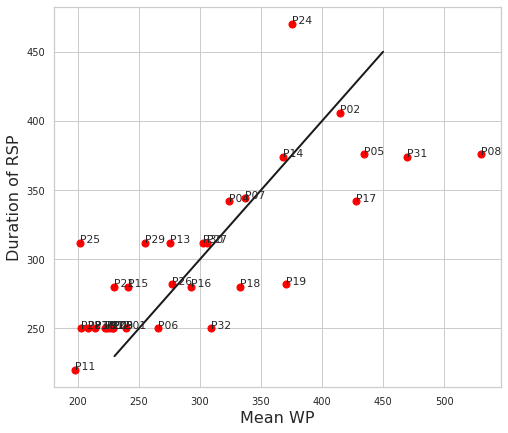

In [961]:
# correlation mean within pauses- respites 

Study = 'BML12'

# get the Margin line 'All' for Mean values per participant
m = pivotBiCharWW.loc[:, 'nanmean']['Pause'].loc['All',:]

# keep only mean WW values for <Study>
m1 = m.loc[:,m.columns.str.contains(Study)]

# get the mean values for WW
aa = np.array(list(m1.iloc[0,:]))

# add 10%
aa += aa/10


sns.set(font_scale=0.9)
sns.set_style("whitegrid")

# MEAN of median WW IKI per Part 
DFlng = DFpauses[DFpauses.index.str.startswith(Study)]
bb = np.array(list(DFlng['R']))

# Plot Pause distributions 
plt.figure(figsize=(8,7))
plt.scatter(aa, bb, c='red', s=50, marker='o')

# strip of 
prts = [p.lstrip('BML12_)') for p in list(DFlng.index)]

for i, p in enumerate(prts):
    plt.annotate(p, (aa[i], bb[i]))
    
plt.plot([230, 450], [230, 450], 'k-', lw=2)

plt.xlabel('Mean WP', size=16)
plt.ylabel('Duration of RSP', size=16)

r, p = scipy.stats.spearmanr(aa,bb)
print(f"Pearson correlation:{r:4.2f} p:{p:4.6f}")